In [15]:

import numpy as np
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
from scipy.special import gammaln

# Convergence

In [3]:
def normal_logp(x, mu, sigma):
    return -0.5 * ((x - mu) / sigma) ** 2 - pm.math.log(sigma) - 0.5*pm.math.log(2*np.pi)
def normal_logp_np(x, mu, sigma):
    return -0.5 * ((x - mu) / sigma) ** 2 - np.log(sigma) - 0.5*np.log(2*np.pi)

In [96]:
n = 20
x = stats.norm.rvs(size=n)
mu_prior_mean = 0
mu_prior_sigma = 1

In [97]:
with pm.Model() as m:

    # traditional analysis
    mu = pm.Normal('mu', mu=mu_prior_mean, sigma=mu_prior_sigma, shape=1)    
    y = pm.Normal('y', mu=mu, sigma=1, observed=x)
    
    # "empty model" MCMC sample over prior and prior predictive data
    mu_ = pm.Normal('mu_', mu=mu_prior_mean, sigma=mu_prior_sigma, shape=1)  
    #bias against
    x_ = pm.Normal('x_', mu=mu_, sigma=1, shape=n)
    
    #one dimension
    #bias for (estimation)
    #x_ = pm.Normal('x_', mu=mu_+delta, sigma=1, shape=n)
    #x_ = pm.Normal('x_', mu=mu_-delta, sigma=1, shape=n)
    #x_ = pm.Normal('x_', mu=[mu_-delta,mu_+delta], sigma=1, shape=n) #might not working,just showing
    
    # prior predictive data density evaluations
    prior_prior_pd = pm.Deterministic("prior_prior_pd", normal_logp(mu_,0,1))
    
    posterior_var = 1/(1/mu_prior_sigma**2 + n/1)
    posterior_mean = (mu_prior_mean/mu_prior_sigma**2 + x_.sum()/1)*posterior_var
    posterior_prior_pd = pm.Deterministic("posterior_prior_pd", 
                                          normal_logp(mu_, posterior_mean, posterior_var**0.5))
    logRB_prior_pd = pm.Deterministic("logRB_prior_pd", posterior_prior_pd-prior_prior_pd) # pm.math.exp()
    
    likelihood_prior_pd = pm.Deterministic("likelihood_prior_pd", normal_logp(x_,mu_,1).sum())

In [98]:
with m:
    idata5000 = pm.sample(draws=5000)
    idata1000 = pm.sample(draws=1000)
    idata700 = pm.sample(draws=700)
    idata500 = pm.sample(draws=500)
    idata300 = pm.sample(draws=300)
    idata100 = pm.sample(draws=100)

Sampling 4 chains, 0 divergences ━━━━━━━━━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━  71% 0:00:08 / 0:00:20

Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 44 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, mu_, x_]


Output()

Sampling 4 chains for 1_000 tune and 300 draw iterations (4_000 + 1_200 draws total) took 43 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, mu_, x_]


Output()

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 33 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


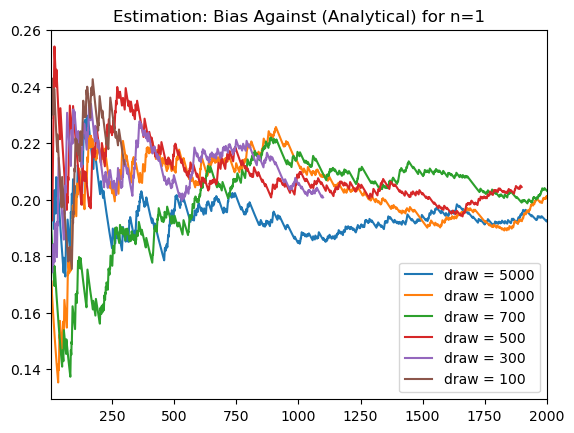

In [77]:
burn = 100

# draw = 5000
bias_against5000 = idata5000.posterior['logRB_prior_pd'].values.ravel()<=0
t = bias_against5000.shape[0]
bias_against_mci5000 = bias_against5000.cumsum()/np.arange(1,t+1)

# draw = 1000
bias_against1000 = idata1000.posterior['logRB_prior_pd'].values.ravel()<=0
t = bias_against1000.shape[0]
bias_against_mci1000 = bias_against1000.cumsum()/np.arange(1,t+1)

# draw = 700
bias_against700 = idata700.posterior['logRB_prior_pd'].values.ravel()<=0
t = bias_against700.shape[0]
bias_against_mci700 = bias_against700.cumsum()/np.arange(1,t+1)

# draw = 500
bias_against500 = idata500.posterior['logRB_prior_pd'].values.ravel()<=0
t = bias_against500.shape[0]
bias_against_mci500 = bias_against500.cumsum()/np.arange(1,t+1)

# draw = 300
bias_against300 = idata300.posterior['logRB_prior_pd'].values.ravel()<=0
t = bias_against300.shape[0]
bias_against_mci300 = bias_against300.cumsum()/np.arange(1,t+1)

# draw = 100
bias_against100 = idata100.posterior['logRB_prior_pd'].values.ravel()<=0
t = bias_against100.shape[0]
bias_against_mci100 = bias_against100.cumsum()/np.arange(1,t+1)


plt.plot(bias_against_mci5000[burn:], label = "draw = 5000"); 
plt.plot(bias_against_mci1000[burn:], label = "draw = 1000"); 
plt.plot(bias_against_mci700[burn:], label = "draw = 700"); 
plt.plot(bias_against_mci500[burn:], label = "draw = 500"); 
plt.plot(bias_against_mci300[burn:], label = "draw = 300"); 
plt.plot(bias_against_mci100[burn:], label = "draw = 100"); 
plt.title("Estimation: Bias Against (Analytical) for n={}".format(n))
plt.xlim(2, 2000)
plt.legend(loc='lower right')

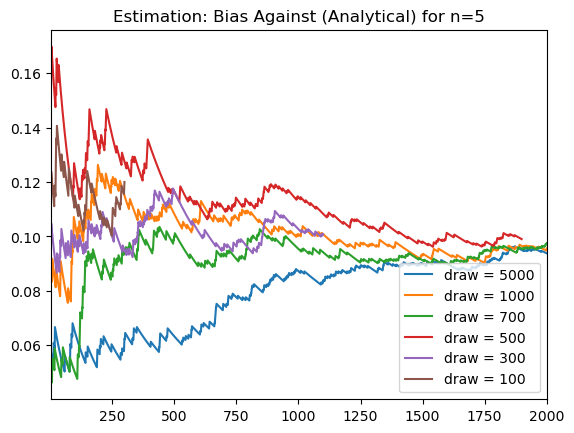

In [73]:
burn = 100

# draw = 5000
bias_against5000 = idata5000.posterior['logRB_prior_pd'].values.ravel()<=0
t = bias_against5000.shape[0]
bias_against_mci5000 = bias_against5000.cumsum()/np.arange(1,t+1)

# draw = 1000
bias_against1000 = idata1000.posterior['logRB_prior_pd'].values.ravel()<=0
t = bias_against1000.shape[0]
bias_against_mci1000 = bias_against1000.cumsum()/np.arange(1,t+1)

# draw = 700
bias_against700 = idata700.posterior['logRB_prior_pd'].values.ravel()<=0
t = bias_against700.shape[0]
bias_against_mci700 = bias_against700.cumsum()/np.arange(1,t+1)

# draw = 500
bias_against500 = idata500.posterior['logRB_prior_pd'].values.ravel()<=0
t = bias_against500.shape[0]
bias_against_mci500 = bias_against500.cumsum()/np.arange(1,t+1)

# draw = 300
bias_against300 = idata300.posterior['logRB_prior_pd'].values.ravel()<=0
t = bias_against300.shape[0]
bias_against_mci300 = bias_against300.cumsum()/np.arange(1,t+1)

# draw = 100
bias_against100 = idata100.posterior['logRB_prior_pd'].values.ravel()<=0
t = bias_against100.shape[0]
bias_against_mci100 = bias_against100.cumsum()/np.arange(1,t+1)


plt.plot(bias_against_mci5000[burn:], label = "draw = 5000"); 
plt.plot(bias_against_mci1000[burn:], label = "draw = 1000"); 
plt.plot(bias_against_mci700[burn:], label = "draw = 700"); 
plt.plot(bias_against_mci500[burn:], label = "draw = 500"); 
plt.plot(bias_against_mci300[burn:], label = "draw = 300"); 
plt.plot(bias_against_mci100[burn:], label = "draw = 100"); 
plt.title("Estimation: Bias Against (Analytical) for n={}".format(n))
plt.xlim(2, 2000)
plt.legend(loc='lower right')

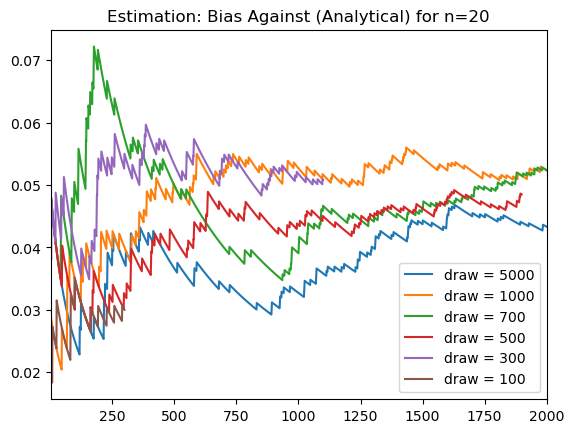

In [99]:
burn = 100

# draw = 5000
bias_against5000 = idata5000.posterior['logRB_prior_pd'].values.ravel()<=0
t = bias_against5000.shape[0]
bias_against_mci5000 = bias_against5000.cumsum()/np.arange(1,t+1)

# draw = 1000
bias_against1000 = idata1000.posterior['logRB_prior_pd'].values.ravel()<=0
t = bias_against1000.shape[0]
bias_against_mci1000 = bias_against1000.cumsum()/np.arange(1,t+1)

# draw = 700
bias_against700 = idata700.posterior['logRB_prior_pd'].values.ravel()<=0
t = bias_against700.shape[0]
bias_against_mci700 = bias_against700.cumsum()/np.arange(1,t+1)

# draw = 500
bias_against500 = idata500.posterior['logRB_prior_pd'].values.ravel()<=0
t = bias_against500.shape[0]
bias_against_mci500 = bias_against500.cumsum()/np.arange(1,t+1)

# draw = 300
bias_against300 = idata300.posterior['logRB_prior_pd'].values.ravel()<=0
t = bias_against300.shape[0]
bias_against_mci300 = bias_against300.cumsum()/np.arange(1,t+1)

# draw = 100
bias_against100 = idata100.posterior['logRB_prior_pd'].values.ravel()<=0
t = bias_against100.shape[0]
bias_against_mci100 = bias_against100.cumsum()/np.arange(1,t+1)


plt.plot(bias_against_mci5000[burn:], label = "draw = 5000"); 
plt.plot(bias_against_mci1000[burn:], label = "draw = 1000"); 
plt.plot(bias_against_mci700[burn:], label = "draw = 700"); 
plt.plot(bias_against_mci500[burn:], label = "draw = 500"); 
plt.plot(bias_against_mci300[burn:], label = "draw = 300"); 
plt.plot(bias_against_mci100[burn:], label = "draw = 100"); 
plt.title("Estimation: Bias Against (Analytical) for n={}".format(n))
plt.xlim(2, 2000)
plt.legend(loc='lower right')

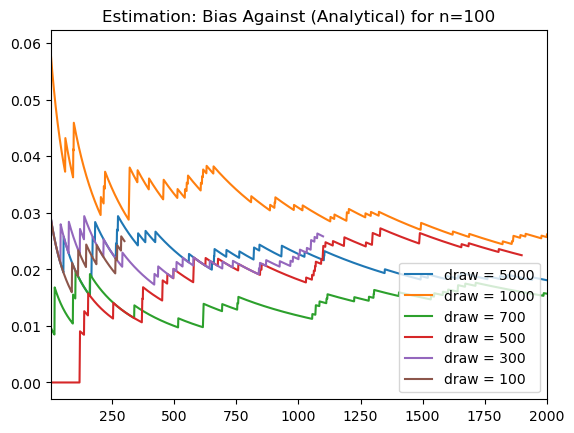

In [95]:
burn = 100

# draw = 5000
bias_against5000 = idata5000.posterior['logRB_prior_pd'].values.ravel()<=0
t = bias_against5000.shape[0]
bias_against_mci5000 = bias_against5000.cumsum()/np.arange(1,t+1)

# draw = 1000
bias_against1000 = idata1000.posterior['logRB_prior_pd'].values.ravel()<=0
t = bias_against1000.shape[0]
bias_against_mci1000 = bias_against1000.cumsum()/np.arange(1,t+1)

# draw = 700
bias_against700 = idata700.posterior['logRB_prior_pd'].values.ravel()<=0
t = bias_against700.shape[0]
bias_against_mci700 = bias_against700.cumsum()/np.arange(1,t+1)

# draw = 500
bias_against500 = idata500.posterior['logRB_prior_pd'].values.ravel()<=0
t = bias_against500.shape[0]
bias_against_mci500 = bias_against500.cumsum()/np.arange(1,t+1)

# draw = 300
bias_against300 = idata300.posterior['logRB_prior_pd'].values.ravel()<=0
t = bias_against300.shape[0]
bias_against_mci300 = bias_against300.cumsum()/np.arange(1,t+1)

# draw = 100
bias_against100 = idata100.posterior['logRB_prior_pd'].values.ravel()<=0
t = bias_against100.shape[0]
bias_against_mci100 = bias_against100.cumsum()/np.arange(1,t+1)


plt.plot(bias_against_mci5000[burn:], label = "draw = 5000"); 
plt.plot(bias_against_mci1000[burn:], label = "draw = 1000"); 
plt.plot(bias_against_mci700[burn:], label = "draw = 700"); 
plt.plot(bias_against_mci500[burn:], label = "draw = 500"); 
plt.plot(bias_against_mci300[burn:], label = "draw = 300"); 
plt.plot(bias_against_mci100[burn:], label = "draw = 100"); 
plt.title("Estimation: Bias Against (Analytical) for n={}".format(n))
plt.xlim(2, 2000)
plt.legend(loc='lower right')

# Beta Model

## Bias Against

In [40]:
alpha0 = 4
beta0 = 4
n = 20  # number of observations
theta0 = 0.5
x = np.random.binomial(1, theta0,n)


In [41]:
def beta_logp(a, b, x):
    return (a - 1) * pm.math.log(x) + (b - 1) * pm.math.log(1 - x) - (gammaln(a) + gammaln(b) - gammaln(a + b))

In [42]:
with pm.Model() as m:
    
    # Traditional analysis
    theta = pm.Beta("theta", alpha=alpha0, beta=beta0)
    y = pm.Bernoulli("y", p=theta, observed=x)
    
    # "empty model" MCMC sample over prior and prior predictive data
    theta_ = pm.Beta("theta_", alpha=alpha0, beta=beta0)

    # Bias against
    x_ = pm.Bernoulli("x_", p=theta_, shape=n)
    
    # Prior predictive data density evaluations
    prior_prior_pd = pm.Deterministic("prior_prior_pd", beta_logp(alpha0, beta0, theta_))

    # Posterior calculations
    posterior_alpha = n * np.mean(x) + alpha0
    posterior_beta = n * (1 - np.mean(x)) + beta0
    posterior_prior_pd = pm.Deterministic("posterior_prior_pd", beta_logp(posterior_alpha, posterior_beta, theta_))

    # log RB ratio
    logRB_prior_pd = pm.Deterministic("logRB_prior_pd", posterior_prior_pd - prior_prior_pd)
    
    likelihood_prior_pd = pm.Deterministic("likelihood_prior_pd", beta_logp(posterior_alpha, posterior_beta, theta_).sum())
    
    # Sample from the model
    idata = pm.sample(1000, return_inferencedata=True)


Sampling 4 chains, 0 divergences ━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━━━━  43% 0:00:15 / 0:00:10

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 38 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


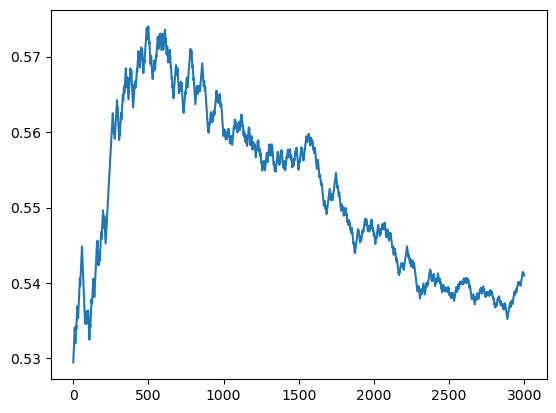

In [51]:
bias_against = idata.posterior['logRB_prior_pd'].values.ravel()<=0
t = bias_against.shape[0]
bias_against_mci = bias_against.cumsum()/np.arange(1,t+1)
burn = 1000
plt.plot(bias_against_mci[burn:]); 

## Simulation

In [48]:
def bernoulli_logp(p, x):
    return x * np.log(p) + (1 - x) * np.log(1 - p)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


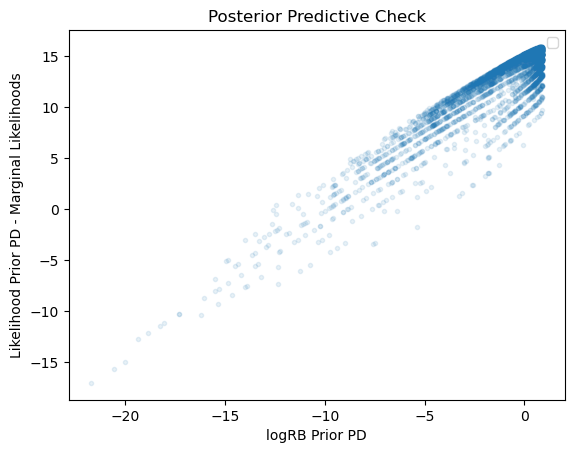

In [57]:
use = 1000
marginal_likelihoods = np.zeros(list(idata.posterior['x_'].values.shape) + [use])
for i, m in enumerate(idata.posterior['theta_'].values.ravel()[:use]):
    marginal_likelihoods[:, :, :, i] = bernoulli_logp(m, idata.posterior['x_'].values)  # Getting likelihoods for each x_ under each theta_

marginal_likelihoods_ = np.log(np.exp(marginal_likelihoods.sum(axis=2)).mean(axis=-1).ravel())  # Summing the log likelihoods and then taking the average over the parameter samples

plt.plot(idata.posterior['logRB_prior_pd'].values.ravel(), 
         idata.posterior['likelihood_prior_pd'].values.ravel() - marginal_likelihoods_, '.', alpha=0.1)
plt.xlabel('logRB Prior PD')
plt.ylabel('Likelihood Prior PD - Marginal Likelihoods')
plt.title('Posterior Predictive Check')
plt.legend()
plt.show()

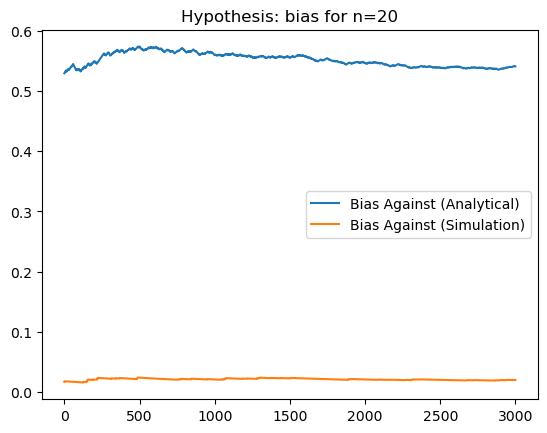

In [59]:
# Analytics
bias_against = idata.posterior['logRB_prior_pd'].values.ravel() <= 0
t = bias_against.shape[0]
burn = 1000
bias_against_mci = bias_against.cumsum()/np.arange(1,t+1)
plt.plot(bias_against_mci[burn:], label='Bias Against (Analytical)')

# Simulation
bias_against_ml = (idata.posterior['likelihood_prior_pd'].values.ravel()-marginal_likelihoods_) <= 0
bias_against_ml_mci = bias_against_ml.cumsum()/np.arange(1,t+1)
plt.plot(bias_against_ml_mci[burn:], label='Bias Against (Simulation)')

plt.title("Hypothesis: bias for n={}".format(n))
plt.legend()

## Bias in Flavor for Beta Model

In [65]:
alpha0 = 4
beta0 = 4
n = 20  # number of observations
delta = 0.05
theta0 = 0.5
data1 = np.random.binomial(1, theta0+delta, n)
data2 = np.random.binomial(1,theta0-delta, n)


In [66]:
with pm.Model() as modBias:
    theta = pm.Beta('theta', alpha = alpha0, beta = beta0)
    xl_ = pm.Bernoulli('xl_', p=theta0-delta, shape=n)
    xu_ = pm.Bernoulli('xu_', p=theta0+delta, shape=n)

    posterior_pd1 = pm.Beta('posterior_pd1', alpha = np.sum(data1)+alpha0, beta = n-np.sum(data1)+beta0)
    posterior_pd2 = pm.Beta('posterior_pd2', alpha = np.sum(data2)+alpha0, beta = n-np.sum(data2)+beta0)

    BR_prior_pd1 = pm.Deterministic("BR_prior_pd1", posterior_pd1/theta)
    BR_prior_pd2 = pm.Deterministic("BR_prior_pd2", posterior_pd2/theta)

    # Likelihood for data1
    p_data1 = pm.math.switch(data1, theta, 1 - theta)
    likelihood_data1 = pm.Deterministic("likelihood_data1", pm.math.prod(p_data1))

    # Likelihood for data2
    p_data2 = pm.math.switch(data2, theta, 1 - theta)
    likelihood_data2 = pm.Deterministic("likelihood_data2", pm.math.prod(p_data2))
    

    # Sample from posterior
    trace = pm.sample(2000, tune=1000)

bias_forlower = trace.posterior['BR_prior_pd1'].values.ravel() > 1
bias_forupper = trace.posterior['BR_prior_pd2'].values.ravel() > 1
tlower = bias_forlower.shape[0]
tupper = bias_forupper.shape[0]
burn = 1000
bias_forlower_mci = bias_forlower.cumsum()/np.arange(1,tlower+1)
bias_forupper_mci = bias_forupper.cumsum()/np.arange(1,tupper+1)



Sampling 4 chains, 0 divergences ━━━━━━━━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━  68% 0:00:09 / 0:00:23

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 47 seconds.


In [67]:
with pm.Model() as minflavor:
    theta = pm.Beta("theta", alpha=alpha0, beta=beta0)
    xl_ = pm.Bernoulli('xl_', p=theta0-delta, shape=n)
    xu_ = pm.Bernoulli('xu_', p=theta0+delta, shape=n)
   
    prior_prior_pd = pm.Deterministic("prior_prior_pd", beta_logp(alpha0, beta0, theta))

    # Posterior calculations
    posterior_alpha1 = n * np.mean(data1) + alpha0
    posterior_beta1 = n * (1 - np.mean(data1)) + beta0
    posterior_prior_pd1 = pm.Deterministic("posterior_prior_pd1", beta_logp(posterior_alpha1, posterior_beta1, theta))

    posterior_alpha2 = n * np.mean(data2) + alpha0
    posterior_beta2 = n * (1 - np.mean(data2)) + beta0
    posterior_prior_pd2 = pm.Deterministic("posterior_prior_pd2", beta_logp(posterior_alpha2, posterior_beta2, theta))

    # log RB ratio
    logRB_prior_pd1 = pm.Deterministic("logRB_prior_pd1", posterior_prior_pd1 - prior_prior_pd)
    logRB_prior_pd2 = pm.Deterministic("logRB_prior_pd2", posterior_prior_pd2 - prior_prior_pd)

    likelihood_prior_pd1 = pm.Deterministic("likelihood_prior_pd1", beta_logp(posterior_alpha1, posterior_beta1, theta).sum())
    likelihood_prior_pd2 = pm.Deterministic("likelihood_prior_pd2", beta_logp(posterior_alpha2, posterior_beta2, theta).sum())
    
    # Sample from the model
    inflavor = pm.sample(1000, return_inferencedata=True)

Sampling 4 chains, 0 divergences ━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━━━━━  40% 0:00:17 / 0:00:10

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Sampling 4 chains, 0 divergences ━━━━━━━━━━━━━━━━━━━━━━━━━━╸━━━━━━━━━━━━━  67% 0:00:09 / 0:00:17

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 41 seconds.


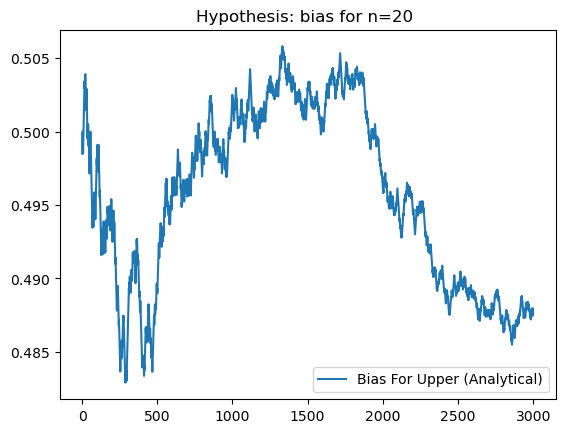

In [68]:
bias_against = inflavor.posterior['logRB_prior_pd1'].values.ravel()>=0
t = bias_against.shape[0]
bias_against_mci = bias_against.cumsum()/np.arange(1,t+1)
burn = 1000
plt.plot(bias_against_mci[burn:], label='Bias For Upper (Analytical)')
plt.title("Hypothesis: bias for n={} ".format(n))
plt.legend()

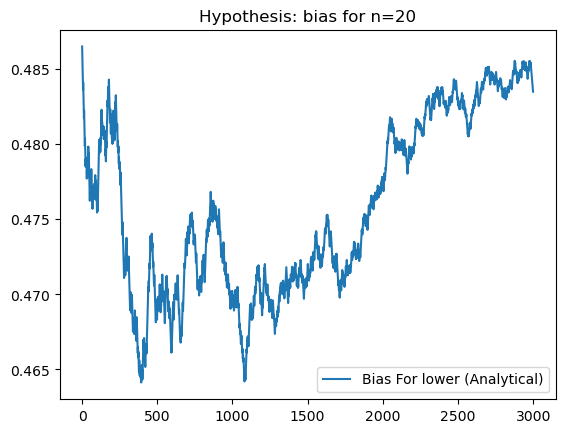

In [69]:
bias_against = inflavor.posterior['logRB_prior_pd2'].values.ravel()>=0
t = bias_against.shape[0]
bias_against_mci = bias_against.cumsum()/np.arange(1,t+1)
burn = 1000
plt.plot(bias_against_mci[burn:], label='Bias For lower (Analytical)')
plt.title("Hypothesis: bias for n={}".format(n))
plt.legend()

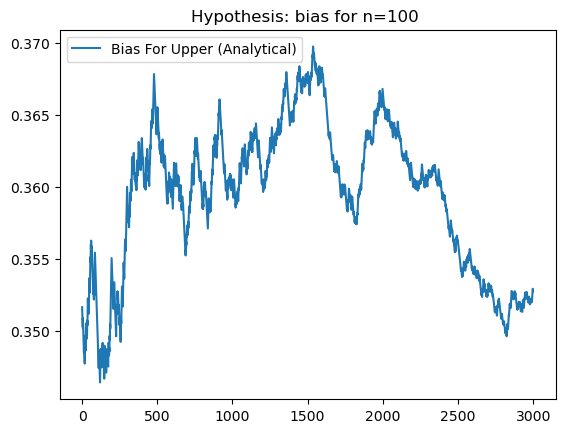

In [38]:
bias_against = inflavor.posterior['logRB_prior_pd1'].values.ravel()>=0
t = bias_against.shape[0]
bias_against_mci = bias_against.cumsum()/np.arange(1,t+1)
burn = 1000
plt.plot(bias_against_mci[burn:], label='Bias For Upper (Analytical)')
plt.title("Hypothesis: bias for n={} ".format(n))
plt.legend()

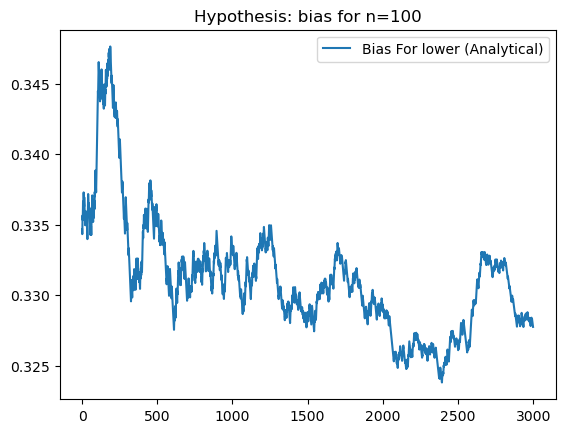

In [39]:
bias_against = inflavor.posterior['logRB_prior_pd2'].values.ravel()>=0
t = bias_against.shape[0]
bias_against_mci = bias_against.cumsum()/np.arange(1,t+1)
burn = 1000
plt.plot(bias_against_mci[burn:], label='Bias For lower (Analytical)')
plt.title("Hypothesis: bias for n={}".format(n))
plt.legend()